In [1]:
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

In [2]:
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
SPLIT = ['sample']
N_CLASSES = 6
CLASSES = [1, 2, 3, 4, 5, 6]
PALETTE = ['#F08080', '#98FF00', '#228B22', '#FFC82D', '#A15622', '#000000']
SAMPLE_PATH = '../Conv1D_LULC_Classification/lc_gabung.csv'
IMAGE_PATH = '../Conv1D_LULC_Classification/Sentinel_Pidie_Agustus_2024.tif'

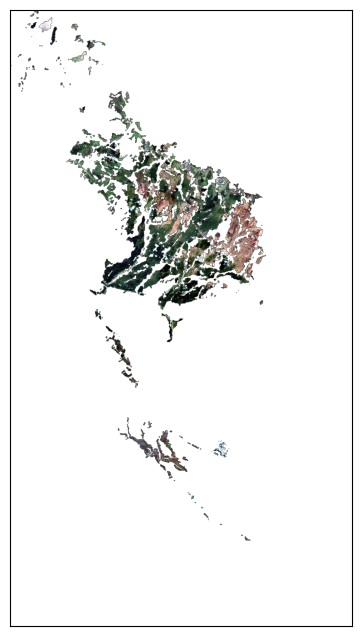

<Axes: >

In [3]:
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [1,2,3]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [4]:
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B8,B11,B12,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
390644,0.21330,0.21670,0.20690,0.19090,0.34380,0.24750,0.21500,0.442445,0.230494,0.162861,-0.248593,-0.162861,0.070270,33,4,train
338971,0.04440,0.05090,0.08720,0.05470,0.39740,0.21400,0.11490,0.637534,0.551435,0.299967,-0.640116,-0.299967,0.301307,71,5,train
402779,0.04715,0.05490,0.08310,0.09055,0.19615,0.10880,0.05830,0.198840,0.541757,0.286440,-0.404834,-0.286440,0.302214,18,1,train
298340,0.03950,0.03600,0.05680,0.03260,0.24390,0.13050,0.06720,0.451689,0.567985,0.302885,-0.622215,-0.302885,0.320182,37,3,train
269858,0.17870,0.22070,0.24340,0.23570,0.41040,0.37470,0.29520,0.373498,0.163265,0.045472,-0.255430,-0.045472,0.118674,9,5,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34209,0.26070,0.25080,0.26460,0.22700,0.45810,0.29170,0.22130,0.615217,0.348543,0.221926,-0.267746,-0.221926,0.137232,31,4,test
109928,0.36030,0.36135,0.36095,0.34295,0.50495,0.32165,0.27690,0.475059,0.291680,0.221752,-0.166301,-0.221752,0.074764,421,5,train
204081,0.17620,0.17570,0.19040,0.17030,0.37600,0.26360,0.19720,0.476135,0.311933,0.175735,-0.327684,-0.175735,0.144097,255,4,train
404342,0.06330,0.06665,0.09930,0.10270,0.27845,0.17710,0.10465,0.315015,0.453667,0.222478,-0.474255,-0.222478,0.257143,27,1,test


In [5]:
# Split into train and test
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES + 1)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES + 1)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (347872, 14, 1)
Test features: (88380, 14, 1)
Train label: (347872, 7)
Test label: (88380, 7)


In [6]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 64
drop = 0.1
kernel = 2
pool = 2

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel , activation='relu'),
  Conv1D(neuron * 1, kernel, activation='relu'),
  MaxPooling1D(pool,pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  Conv1D(neuron * 2, kernel, activation='relu'),
  MaxPooling1D(pool,pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES + 1, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 64)            192       
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            8256      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 64)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 64)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 128)            16512     
                                                                 
 conv1d_3 (Conv1D)           (None, 4, 128)            32896     
                                                        

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to save the best model based on validation loss
checkpoint = ModelCheckpoint(
    'best_model.h5',                # File path to save the model weights
    monitor='val_loss',             # Monitor the validation loss for saving
    save_best_only=True,            # Save only the best weights (when validation loss improves)
    verbose=1,                      # Show a message when saving the model
    save_weights_only=True,         # Save only weights (if you don't need the entire model)
    mode='min',                     # Minimize validation loss (this is the default)
    save_freq='epoch'               # Save at the end of every epoch
)

# Create callback to stop training if loss is not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True  # Optionally restore the best weights
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop, checkpoint],  # Add the checkpoint callback here
    epochs=100,
    verbose=2
)
'''
# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=10
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop],
    epochs=100,
)
'''

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.04485, saving model to best_model.h5
340/340 - 21s - loss: 1.2276 - accuracy: 0.5230 - val_loss: 1.0448 - val_accuracy: 0.5814 - 21s/epoch - 61ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.04485 to 1.00456, saving model to best_model.h5
340/340 - 20s - loss: 1.0488 - accuracy: 0.5875 - val_loss: 1.0046 - val_accuracy: 0.6012 - 20s/epoch - 59ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.00456 to 0.98003, saving model to best_model.h5
340/340 - 20s - loss: 1.0117 - accuracy: 0.6048 - val_loss: 0.9800 - val_accuracy: 0.6097 - 20s/epoch - 58ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.98003 to 0.97428, saving model to best_model.h5
340/340 - 23s - loss: 0.9895 - accuracy: 0.6156 - val_loss: 0.9743 - val_accuracy: 0.6221 - 23s/epoch - 68ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.97428 to 0.95715, saving model to best_model.h5
340/340 - 23s - loss: 0.9769 - accuracy: 0.6212 - val_loss: 0.9571 - val_

"\n# Create callback to stop training if loss not decreasing\nstop = EarlyStopping(\n    monitor='loss',\n    patience=10\n)\n\n# Fit the model\nresult = model.fit(\n    x=train_input, y=train_output,\n    validation_data=(test_input, test_output),\n    batch_size=1024,\n    callbacks=[stop],\n    epochs=100,\n)\n"

52/52 [==============================] - 11s 201ms/step


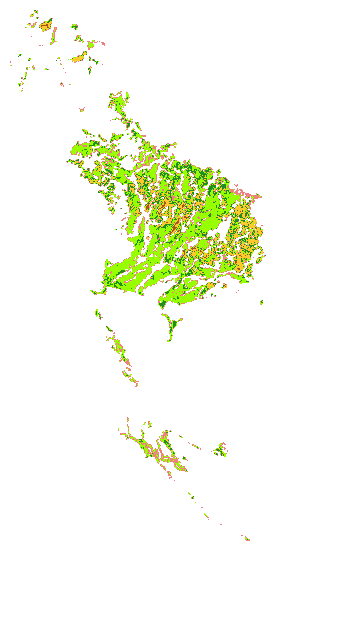

In [11]:
# Predict image using the model
image_input = []
for x in range(14):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(14, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
fig, ax = plt.subplots(figsize=plot_size)
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size, ax = ax, cbar=False)
ax.set_axis_off()

plt.show()

In [12]:
import rasterio

# Membuka file citra
with rasterio.open(IMAGE_PATH) as src:
    # Mendapatkan informasi resolusi spasial
    resolution = src.res
    print(f'Resolusi spasial: {resolution}')
    print(f'Resolusi spasial: {0.00026949458523585647*111320} meter/piksel')

Resolusi spasial: (0.00026949458523585647, 0.00026949458523585647)
Resolusi spasial: 30.000137228455543 meter/piksel


In [13]:
# Hitung jumlah piksel untuk setiap kelas
pixel_counts = {class_id: np.sum(prediction == class_id) for class_id in CLASSES}

# Menampilkan jumlah piksel untuk setiap kelas
for class_id, count in pixel_counts.items():
    print(f"Kelas {class_id}: {count} piksel")

# Jika Anda ingin menghitung luas, misalnya, jika setiap piksel mewakili 30x30 meter
# Maka luas per piksel = 30 meter * 30 meter = 900 meter persegi
area_per_pixel = 900  # dalam meter persegi, sesuaikan dengan resolusi citra Anda

# Hitung luas total per kelas
area_by_class = {class_id: count * area_per_pixel for class_id, count in pixel_counts.items()}

# Menampilkan luas total untuk setiap kelas
for class_id, area in area_by_class.items():
    print(f"Kelas {class_id}: {area/10000} hectare")

Kelas 1: 18104 piksel
Kelas 2: 123974 piksel
Kelas 3: 75415 piksel
Kelas 4: 11181 piksel
Kelas 5: 89579 piksel
Kelas 6: 1745 piksel
Kelas 1: 1629.36 hectare
Kelas 2: 11157.66 hectare
Kelas 3: 6787.35 hectare
Kelas 4: 1006.29 hectare
Kelas 5: 8062.11 hectare
Kelas 6: 157.05 hectare


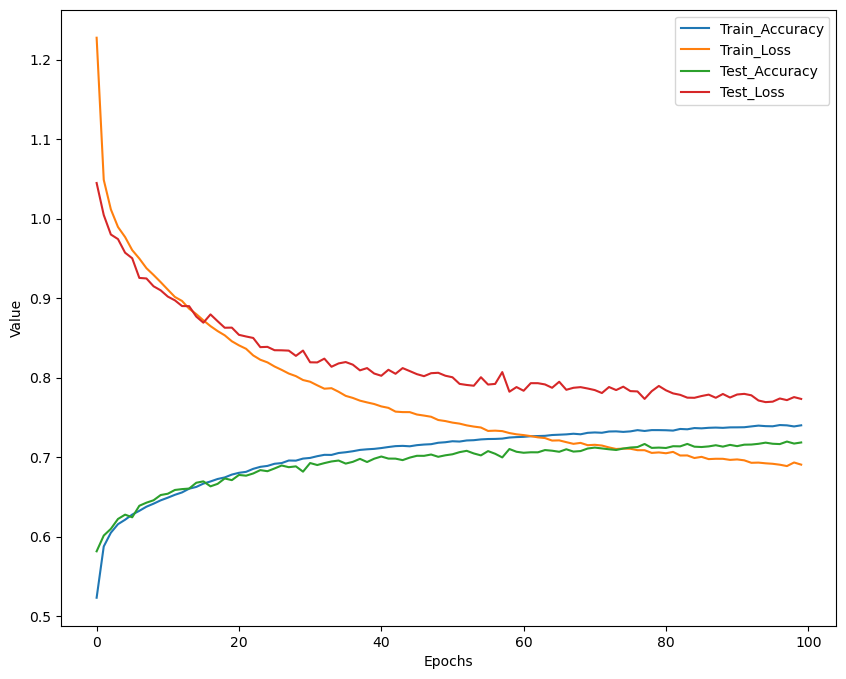

In [14]:
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

10871/10871 [==============================] - 9s 856us/step
              precision    recall  f1-score   support

           1       0.78      0.70      0.74     67425
           2       0.72      0.71      0.72     49150
           3       0.70      0.72      0.71     40493
           4       0.76      0.76      0.76     44651
           5       0.82      0.90      0.86    137327
           6       0.59      0.07      0.12      8826

    accuracy                           0.78    347872
   macro avg       0.73      0.65      0.65    347872
weighted avg       0.77      0.78      0.77    347872



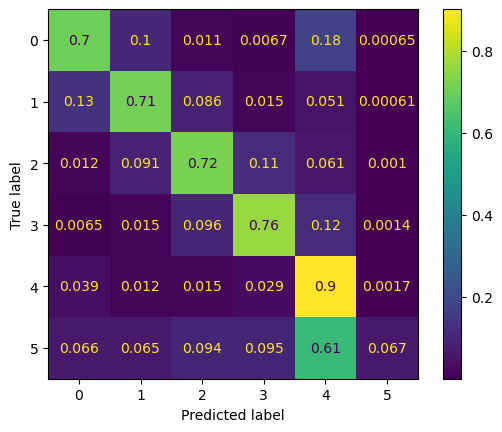

In [15]:
prediction = np.argmax(model.predict(train_input), 1).flatten()
label = np.argmax(train_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

2762/2762 [==============================] - 2s 887us/step
              precision    recall  f1-score   support

           1       0.72      0.65      0.68     17009
           2       0.69      0.64      0.67     13304
           3       0.62      0.64      0.63     10292
           4       0.63      0.69      0.66     10844
           5       0.78      0.85      0.82     34761
           6       0.54      0.05      0.10      2170

    accuracy                           0.72     88380
   macro avg       0.66      0.59      0.59     88380
weighted avg       0.71      0.72      0.71     88380



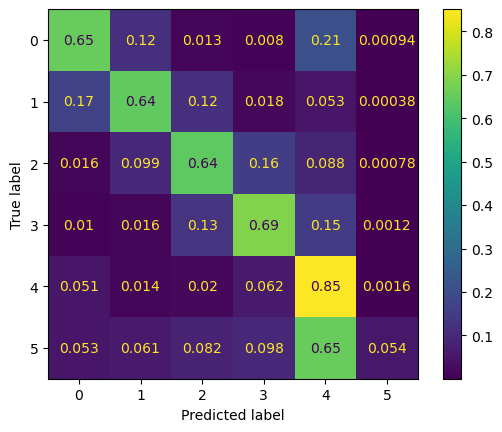

In [16]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score
import numpy as np

In [18]:
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()
cm1 = confusion_matrix(label, prediction, normalize='true')
num_classes = 5
sensitivity = []
specificities = []

# Hitung sensitivitas untuk setiap kelas
for i in range(num_classes):
    TP = cm1[i, i]
    FN = np.sum(cm1[i, :]) - TP  # Jumlah semua FN untuk kelas i
    sensitivity_1 = TP / (TP + FN)
    sensitivity.append(sensitivity_1)

total = 0
for num in sensitivity:
    total += num

print("Sensitivity : ", total/6)

for i in range(num_classes):
    TN = np.sum(cm1) - np.sum(cm1[i, :]) - np.sum(cm1[:, i]) + cm1[i, i]
    FP = np.sum(cm1[:, i]) - cm1[i, i]
    specificity_1 = TN / (TN + FP)
    specificities.append(specificity_1)

total = 0
for num in specificities:
    total += num

print("Specificity : ", total/6)

mcc= matthews_corrcoef(label, prediction)
print('Matthews corrcoef : ',mcc)
KIA=cohen_kappa_score(label, prediction)
print('Cohen Kappa Index : ',KIA)

2762/2762 [==============================] - 2s 890us/step
Sensitivity :  0.5802222241098565
Specificity :  0.7513384674617059
Matthews corrcoef :  0.6237469492902084
Cohen Kappa Index :  0.6227715837078871


In [19]:
prediction = np.argmax(model.predict(train_input), 1).flatten()
label = np.argmax(train_output, 1).flatten()
cm1 = confusion_matrix(label, prediction, normalize='true')
num_classes = 6
sensitivity = []
specificities = []

# Hitung sensitivitas untuk setiap kelas
for i in range(num_classes):
    TP = cm1[i, i]
    FN = np.sum(cm1[i, :]) - TP  # Jumlah semua FN untuk kelas i
    sensitivity_1 = TP / (TP + FN)
    sensitivity.append(sensitivity_1)

total = 0
for num in sensitivity:
    total += num

print("Sensitivity : ", total/6)

for i in range(num_classes):
    TN = np.sum(cm1) - np.sum(cm1[i, :]) - np.sum(cm1[:, i]) + cm1[i, i]
    FP = np.sum(cm1[:, i]) - cm1[i, i]
    specificity_1 = TN / (TN + FP)
    specificities.append(specificity_1)

total = 0
for num in specificities:
    total += num

print("Specificity : ", total/6)

mcc= matthews_corrcoef(label, prediction)
print('Matthews corrcoef : ',mcc)
KIA=cohen_kappa_score(label, prediction)
print('Cohen Kappa Index : ',KIA)

10871/10871 [==============================] - 9s 860us/step
Sensitivity :  0.6450205779097437
Specificity :  0.9290041155819487
Matthews corrcoef :  0.7014411965982266
Cohen Kappa Index :  0.7001188592335424


2762/2762 [==============================] - 2s 870us/step


C:\Users\jabir\AppData\Local\Temp\ipykernel_40860\1033332930.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 8)


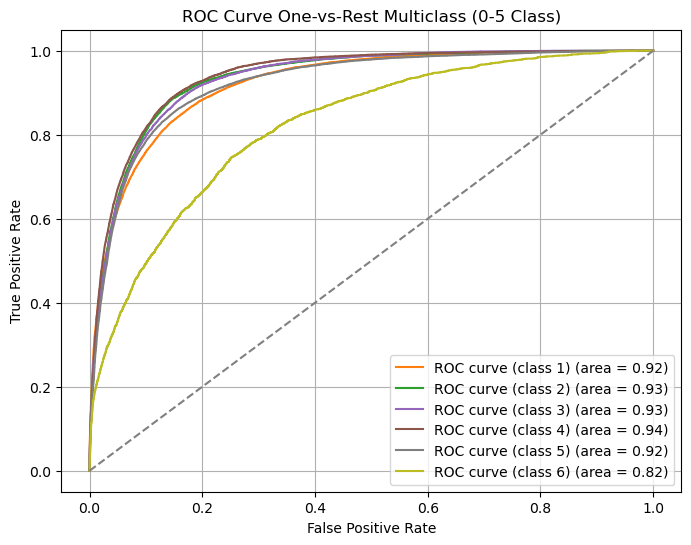

In [20]:
y_prob = model.predict(test_input)

# Hitung ROC curve dan AUC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1,7):
    fpr[i], tpr[i], _ = roc_curve(test_output[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve untuk setiap kelas
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', 8)

for i in range(1,7):
    plt.plot(fpr[i], tpr[i], color=colors(i),
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

# Plot garis diagonal untuk referensi
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Tambahkan label dan judul pada plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve One-vs-Rest Multiclass (0-5 Class)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

10871/10871 [==============================] - 9s 854us/step


C:\Users\jabir\AppData\Local\Temp\ipykernel_40860\319121698.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 6)


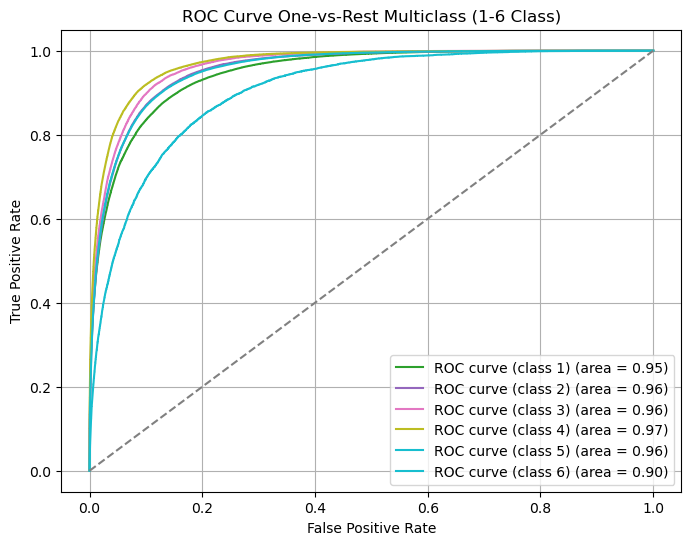

In [21]:
y_prob = model.predict(train_input)

# Hitung ROC curve dan AUC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1,7):
    fpr[i], tpr[i], _ = roc_curve(train_output[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve untuk setiap kelas
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', 6)

for i in range(1,7):
    plt.plot(fpr[i], tpr[i], color=colors(i),
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

# Plot garis diagonal untuk referensi
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Tambahkan label dan judul pada plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve One-vs-Rest Multiclass (1-6 Class)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()